# Compound Flooding Analysis 

**Objective:** Quantify the relationship between river discharge and offshore water level extremes at the Volta River Estuary to assess compound flooding potential.

**Study Area:**
- Volta River Estuary, Ghana
- Estuary bounds: lat [5.73, 5.83]°, lon [0.64, 0.75]°
- Context bounds for maps: lat [3, 9]°, lon [−3, 3]°
- Reference points: at the mouth river (0.667E  5.77N) and at the Volta Lake (0.117E, 6.5N)

**Datasets:**
- **GloFAS v4.0**: Daily river discharge in the last 24h (`dis24`), units m³/s, 2010–2021.
- **JRC Maximum Daily Global Open Ocean Water Level**: Offshore daily maximum WL, units 10⁻⁴ m, 1959–2021.

In [52]:
# --- Reproducibility & environment check ---
import sys, platform

print("Interpreter:", sys.executable)
print("Python     :", sys.version.split()[0])
print("Platform   :", platform.platform())

def check(modname):
    try:
        m = __import__(modname)
        v = getattr(m, "__version__", "installed")
        print(f"{modname:<10} {v}")
    except ImportError:
        print(f"{modname:<10} NOT INSTALLED")

for name in [
    "numpy", "pandas", "xarray", "matplotlib", "cartopy",
    "netCDF4", "cdsapi", "dask"   # dask only needed if you use open_mfdataset
]:
    check(name)


Interpreter: c:\Users\aless\Desktop\tesi\SoC_master_thesis_git\.venv\Scripts\python.exe
Python     : 3.13.4
Platform   : Windows-11-10.0.26100-SP0
numpy      2.3.3
pandas     2.3.2
xarray     2025.9.0
matplotlib 3.10.6
cartopy    0.25.0
netCDF4    1.7.2
cdsapi     installed
dask       2025.7.0


# Import libraries

In [28]:
# Standard library
import os, calendar
import glob

# Scientific computing
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
from typing import Dict, List

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Geospatial
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# cds
from cds_request import cds_request_keta
import cdsapi


In [7]:
##### Define useful functions #####
def detrend_dim(da, dim="time", deg=1, baseline=None, return_trend=False, skipna=True):
    """
    Polynomial detrend along `dim` using xarray's native datetime handling.
    Optionally fit on a `baseline=(start, end)` window, apply to full series.
    """
    da_fit = da.sel({dim: slice(*baseline)}) if baseline else da
    p = da_fit.polyfit(dim=dim, deg=deg, skipna=skipna)
    fit = xr.polyval(da[dim], p.polyfit_coefficients).astype(da.dtype)
    detr = (da - fit).assign_attrs(da.attrs)
    detr.name = (da.name or "var") + "_detrended"
    if return_trend:
        fit.name = (da.name or "var") + "_trend"
        return detr, fit
    return detr

def anom(xarr, baseline=('2010-01-01','2021-12-31')):
    base = xarr.sel(time=slice(*baseline)) if baseline else xarr
    clim = base.groupby('time.month').mean('time')
    ano  = xarr.groupby('time.month') - clim
    return ano, clim

def anomd(xarr, baseline=('2010-01-01','2021-12-31'), deg=1):
    x_det, trend = detrend_dim(xarr, dim='time', deg=deg, baseline=baseline, return_trend=True)
    base_det = x_det.sel(time=slice(*baseline)) if baseline else x_det
    clim_d = base_det.groupby('time.month').mean('time')
    ano_d  = x_det.groupby('time.month') - clim_d
    return ano_d, clim_d, trend

# Study Area

In [8]:
# Define bounds for the Volta River Estuary Area
lat_min, lat_max = 5.73, 5.83
lon_min, lon_max = 0.64, 0.75

# Full map bounds
full_lat_min, full_lat_max = 3, 9
full_lon_min, full_lon_max = -3, 3

# Specific points
lon_estuary, lat_estuary = 0.667, 5.77 # these coordinates are chosen at the estuary, near Ada Foah
lon_lake, lat_lake = 0.087, 6.267 # these are the coordinates of the Volta River just downstream of Volta Lake, close to Akosombo.


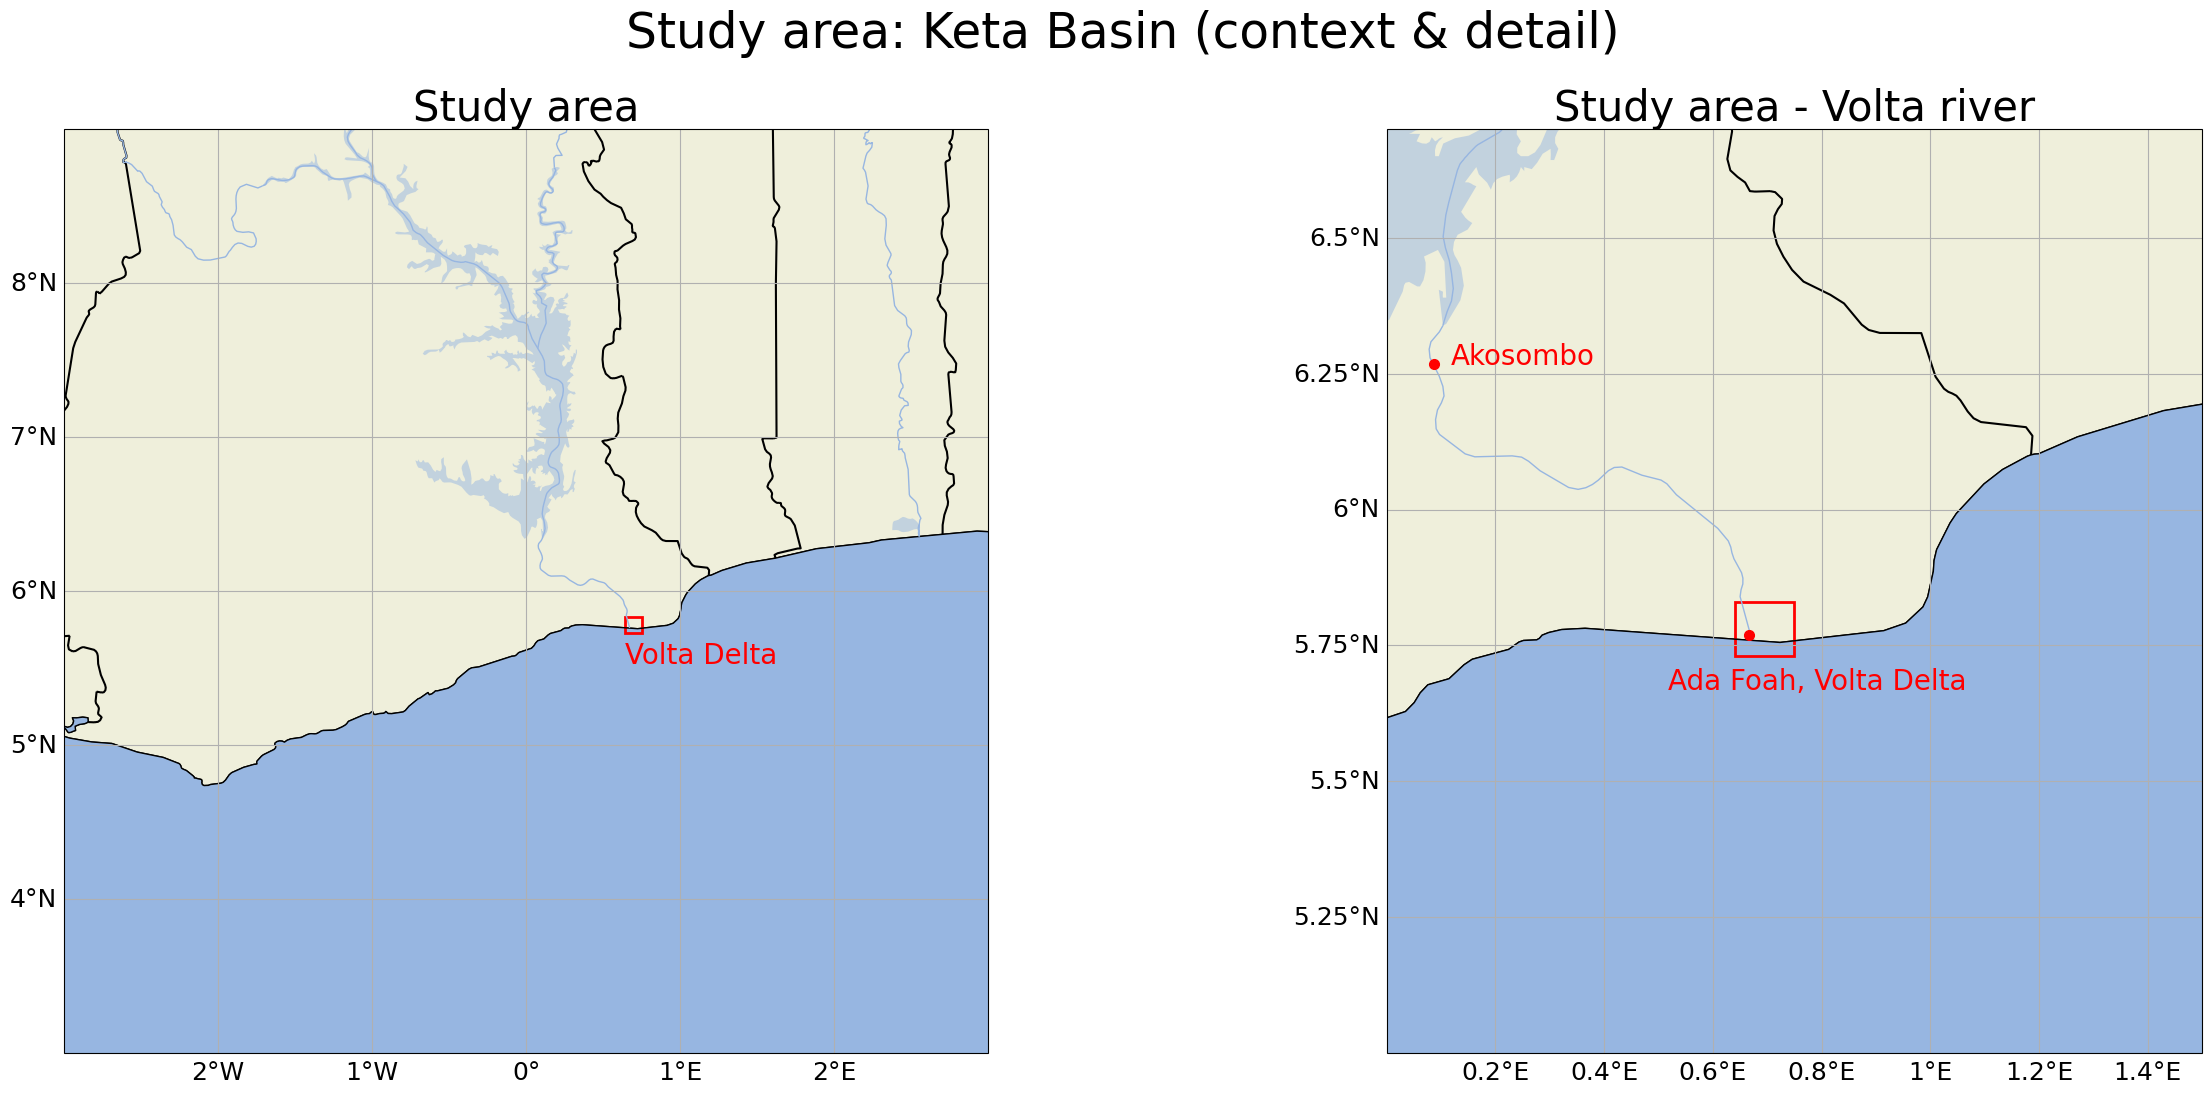

In [57]:
# Create figure and axis with PlateCarree projection
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle("Study area: Keta Basin (context & detail)", fontsize=35)

# First panel: Broad focus Area
ax[0].set_extent([full_lon_min, full_lon_max, full_lat_min, full_lat_max])
ax[0].coastlines(resolution='10m')  # Dettagli costieri
ax[0].add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5)
ax[0].add_feature(cfeature.LAND, edgecolor='black')
ax[0].add_feature(cfeature.RIVERS)
ax[0].add_feature(cfeature.LAKES, alpha=0.5)
ax[0].add_feature(cfeature.OCEAN)
gl0 = ax[0].gridlines(draw_labels=True)
gl0.top_labels = False
gl0.right_labels = False
gl0.xlabel_style = {'fontsize': 18}
gl0.ylabel_style = {'fontsize': 18}
gl0.xformatter = LONGITUDE_FORMATTER
gl0.yformatter = LATITUDE_FORMATTER
ax[0].set_title('Study area', fontsize=30)

# Add rectangle for Keta Estuary subset
from matplotlib.patches import Rectangle

# Add patch (box)
rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                 linewidth=2, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree())
ax[0].add_patch(rect)
ax[0].text(lon_min, lat_max - 0.3, 'Volta Delta', color='red',
        fontsize=20, transform=ccrs.PlateCarree())


# Second panel: detail over the Volta River Estuary 
ax[1].set_extent([0, 1.5, 5, 6.7])
ax[1].coastlines(resolution='10m')  # Dettagli costieri
ax[1].add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5)
ax[1].add_feature(cfeature.LAND, edgecolor='black')
ax[1].add_feature(cfeature.RIVERS)
ax[1].add_feature(cfeature.LAKES, alpha=0.5)
ax[1].add_feature(cfeature.OCEAN)
gl1 = ax[1].gridlines(draw_labels=True)
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {'fontsize': 18}
gl1.ylabel_style = {'fontsize': 18}
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER
ax[1].set_title('Study area - Volta river', fontsize=30)

rect2 = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                  linewidth=2, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree())
ax[1].add_patch(rect2)
ax[1].text(lon_min, lat_max + 0.05, ' ', color='red',
        fontsize=20, transform=ccrs.PlateCarree())
# Add red points 
plt.plot(lon_estuary, lat_estuary, marker='o', color='red', markersize=7)
ax[1].text(lon_estuary -0.15, lat_estuary - 0.1, 'Ada Foah, Volta Delta', color='red',
        fontsize=20, transform=ccrs.PlateCarree())
plt.plot(lon_lake, lat_lake, marker='o', color='red', markersize=7)
ax[1].text(lon_lake + 0.03, lat_lake, 'Akosombo', color='red',
        fontsize=20, transform=ccrs.PlateCarree())


plt.show()

For further analysis, it will be take into account a single point, located at the Volta River Mouth (5.77°N e 0.667°E), and an additional point further upstream, at Volta Lake (6.50°N, 0.117°E).


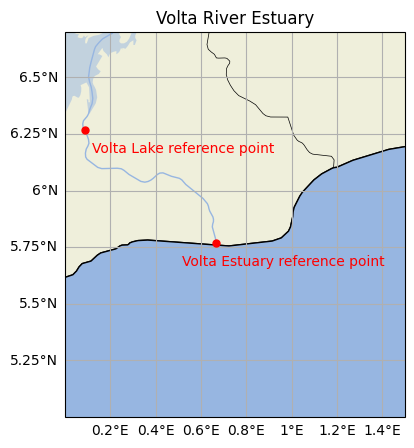

In [10]:
# Base map
plt.figure(figsize=(6,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([0, 1.5, 5, 6.7])
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.OCEAN)
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
  # Add red points 
plt.plot(lon_estuary, lat_estuary, marker='o', color='red', markersize=5)
ax.text(lon_estuary -0.15, lat_estuary - 0.1, 'Volta Estuary reference point', color='red',
        fontsize=10, transform=ccrs.PlateCarree())
plt.plot(lon_lake, lat_lake, marker='o', color='red', markersize=5)
ax.text(lon_lake + 0.03, lat_lake - 0.1, 'Volta Lake reference point', color='red',
        fontsize=10, transform=ccrs.PlateCarree())
plt.title('Volta River Estuary')
plt.show()

# Load and preprocess data

## GloFAS data
**GloFAS v4.0 (cems-glofas-historical)**
- **Source:** CEMS Early Warning Data Store (EWDS), Copernicus (https://ewds.climate.copernicus.eu/datasets/cems-glofas-historical?tab=overview).
- **Time span used here:** 2010–2021 (inclusive), **daily** discharge in last 24h.
- **Variable / units:** `dis24` (river discharge in the last 24 h), m³/s.
- **Spatial subset:** [0–9°N, 3°W–3°E] (area = [N, W, S, E]).
- **Acquisition:** API request kept in code for reproducibility; `dry_run=True` prevents re-downloads (files were already retrieved).
- **Preprocessing:** Per-year NetCDF files concatenated along `time`, sorted by time, duplicates handled; nearest grid cell to (5.77°N, 0.667°E) and (6.50°N, 0.117°E).


In [35]:
# Working directory and configuration
data_dir = "C:/Users/aless/Desktop/tesi/data/glofas_keta"
years: List[int] = list(range(2010, 2022)) # 2010..2021 inclusive
area = [9, -3, 0, 3] # [North, West, South, East] => 0–9°N, 3°W–3°E
dry_run = True       # set to False if you want to download

os.makedirs(data_dir, exist_ok=True)

# Build a valid CDS request
def build_glofas_request(year: int) -> Dict:
    """Build a valid request for cems-glofas-historical."""
    return {
        "format": "netcdf",
        "product_type": "consolidated",
        "variable": "dis24",                     # river discharge in the last 24h
        "year": str(year),
        "month": [f"{m:02d}" for m in range(1, 13)],
        "leadtime_hour": "24",
        "area": area,                            # [N, W, S, E]
    }

# Request wrapper that skips if file exists and supports dry-run
def request_glofas_year(year: int) -> str:
    """
    If dry_run=True -> do NOT download, just show what would be done.
    If dry_run=False -> download only if the file is missing or empty.
    """
    glofas_name = f"glofas_dis24_{year}.nc"
    glofas_path = os.path.join(data_dir, glofas_name)

    # Skip if it's already present
    if os.path.exists(glofas_path) and os.path.getsize(glofas_path) > 0:
        print(f"✔ {glofas_name} already present, skipping download.")
        return glofas_path

    # Build request 
    req = build_glofas_request(year)
    if dry_run:
        print(f"[DRY RUN] Would download {glofas_name} with request = {req}")
        return glofas_path  # pretend target path

    # Real download only when you flip dry_run=False
    print(f"⬇ Downloading {glofas_name} ...")
    c = cdsapi.Client()
    c.retrieve("cems-glofas-historical", req, glofas_path)
    print(f"✔ {glofas_name} downloaded.")
    return glofas_path

# Loop for all years
for y in years:
    request_glofas_year(y)
print("Done (no downloads performed unless dry_run=False and file missing).")


[DRY RUN] Would download glofas_dis24_2010.nc with request = {'format': 'netcdf', 'product_type': 'consolidated', 'variable': 'dis24', 'year': '2010', 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'leadtime_hour': '24', 'area': [9, -3, 0, 3]}
[DRY RUN] Would download glofas_dis24_2011.nc with request = {'format': 'netcdf', 'product_type': 'consolidated', 'variable': 'dis24', 'year': '2011', 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'leadtime_hour': '24', 'area': [9, -3, 0, 3]}
[DRY RUN] Would download glofas_dis24_2012.nc with request = {'format': 'netcdf', 'product_type': 'consolidated', 'variable': 'dis24', 'year': '2012', 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'leadtime_hour': '24', 'area': [9, -3, 0, 3]}
[DRY RUN] Would download glofas_dis24_2013.nc with request = {'format': 'netcdf', 'product_type': 'consolidated', 'variable': 'dis24', 'year': '2013', 'month': 

In [38]:
# Read local files and concatenate (no network)
files_glofas = sorted(glob.glob(os.path.join(data_dir, "*.nc")))
if not files_glofas:
    raise FileNotFoundError(f"No .nc files found in {data_dir}. Put your existing files there.")

# Open and combine files
datasets = [xr.open_dataset(p) for p in files_glofas]
glofas_keta = xr.concat(datasets, dim="time")  
glofas_keta

<xarray.Dataset> Size: 252MB
Dimensions:    (time: 4383, latitude: 120, longitude: 120)
Coordinates:
  * latitude   (latitude) float32 480B 3.025 3.075 3.125 ... 8.875 8.925 8.975
  * longitude  (longitude) float32 480B -2.975 -2.925 -2.875 ... 2.925 2.975
  * time       (time) datetime64[ns] 35kB 2010-02-01 2010-02-02 ... 2021-12-31
Data variables:
    dis24      (time, latitude, longitude) float32 252MB 9.999e+03 ... 0.0

In [39]:
# Checking on and sorting the 'time' variable

# Get a DatetimeIndex for convenience
t = getattr(glofas_keta.indexes, 'time', pd.DatetimeIndex(glofas_keta['time'].values))
print("Count:", t.size)
print("First :", t[0])
print("Last  :", t[-1])

# Sortedness / monotonicity
print("Monotonic increasing:", t.is_monotonic_increasing)
print("Has duplicates      :", t.has_duplicates)

# Peek at the edges
print("Head:", t[:5].tolist())
print("Tail:", t[-5:].tolist())

# Frequency / regularity
print("Inferred frequency  :", t.inferred_freq)  # None => irregular

# Show where ordering is broken (if any)
bad_order_idx = np.where(t[1:] < t[:-1])[0]
print("Out-of-order indices:", bad_order_idx[:10], "(showing up to 10)")

# Gap summary (how many times each delta occurs)
diffs = pd.Series(t[1:] - t[:-1])
print("Most common gaps:\n", diffs.value_counts().head(5))
print("Unique gaps:", pd.unique(diffs))

Count: 4383
First : 2010-02-01 00:00:00
Last  : 2021-12-31 00:00:00
Monotonic increasing: False
Has duplicates      : False
Head: [Timestamp('2010-02-01 00:00:00'), Timestamp('2010-02-02 00:00:00'), Timestamp('2010-02-03 00:00:00'), Timestamp('2010-02-04 00:00:00'), Timestamp('2010-02-05 00:00:00')]
Tail: [Timestamp('2021-12-27 00:00:00'), Timestamp('2021-12-28 00:00:00'), Timestamp('2021-12-29 00:00:00'), Timestamp('2021-12-30 00:00:00'), Timestamp('2021-12-31 00:00:00')]
Inferred frequency  : None
Out-of-order indices: [ 147  512  878 1243 1608 1973 2339 2704 3069 3434] (showing up to 10)
Most common gaps:
 1 days       4251
31 days        48
32 days        47
63 days        12
-333 days       9
Name: count, dtype: int64
Unique gaps: [    86400000000000   2764800000000000   5443200000000000
 -28771200000000000   2505600000000000   2678400000000000
 -28857600000000000   2592000000000000]


In [40]:
# Show the exact out-of-order transitions (with context)
t = glofas_keta.get_index('time')
bad_idx = np.where(t[1:] < t[:-1])[0]  # indices where next < prev
print("Out-of-order count:", bad_idx.size)

# Show a little neighborhood around each break
for i in bad_idx:
    lo = max(0, i-2)
    hi = min(len(t), i+3)
    print(f"\nBreak at i={i} (t[i] -> t[i+1]):")
    print(pd.Series(t[lo:hi]).to_string())

Out-of-order count: 12

Break at i=147 (t[i] -> t[i+1]):
0   2010-11-28
1   2010-11-29
2   2010-11-30
3   2010-01-01
4   2010-01-02

Break at i=512 (t[i] -> t[i+1]):
0   2011-11-28
1   2011-11-29
2   2011-11-30
3   2011-01-01
4   2011-01-02

Break at i=878 (t[i] -> t[i+1]):
0   2012-11-28
1   2012-11-29
2   2012-11-30
3   2012-01-01
4   2012-01-02

Break at i=1243 (t[i] -> t[i+1]):
0   2013-11-28
1   2013-11-29
2   2013-11-30
3   2013-01-01
4   2013-01-02

Break at i=1608 (t[i] -> t[i+1]):
0   2014-11-28
1   2014-11-29
2   2014-11-30
3   2014-01-01
4   2014-01-02

Break at i=1973 (t[i] -> t[i+1]):
0   2015-11-28
1   2015-11-29
2   2015-11-30
3   2015-01-01
4   2015-01-02

Break at i=2339 (t[i] -> t[i+1]):
0   2016-11-28
1   2016-11-29
2   2016-11-30
3   2016-01-01
4   2016-01-02

Break at i=2704 (t[i] -> t[i+1]):
0   2017-11-28
1   2017-11-29
2   2017-11-30
3   2017-01-01
4   2017-01-02

Break at i=3069 (t[i] -> t[i+1]):
0   2018-11-28
1   2018-11-29
2   2018-11-30
3   2018-01-01
4   2

In [41]:
# Sort by time and verify
glofas_sorted = glofas_keta.sortby('time')
ti = glofas_sorted.get_index('time')

print("Monotonic after sort:", ti.is_monotonic_increasing)
print("Start/End after sort:", ti[0], ti[-1])
print("Inferred freq after sort:", ti.inferred_freq)  # still None if gaps remain

Monotonic after sort: True
Start/End after sort: 2010-01-01 00:00:00 2021-12-31 00:00:00
Inferred freq after sort: D


In [42]:
# Identify and list missing dates (daily grid)
full = pd.date_range(t.min(), t.max(), freq='D')
have = glofas_sorted.time.to_index()
missing = full.difference(have)
print("Missing days:", len(missing))
print("First 20 missing:\n", pd.Series(missing[:20]))

# Summarize missing by year
miss_df = pd.DataFrame({"date": missing})
miss_df["year"] = miss_df["date"].dt.year
print(miss_df["year"].value_counts().sort_index())

Missing days: 0
First 20 missing:
 Series([], dtype: datetime64[ns])
Series([], Name: count, dtype: int64)


In [44]:
# Extract raw (daily) values to the point closest to the two points
rd_estuary = glofas_sorted['dis24'].sel(latitude = lat_estuary, longitude = lon_estuary, method='nearest')
rd_lake = glofas_sorted['dis24'].sel(latitude = lat_lake, longitude = lon_lake, method='nearest')

# confirm where we actually landed
sel_estuary_lat = float(rd_estuary.latitude.values)
sel_estuary_lon = float(rd_estuary.longitude.values)
sel_lake_lat  = float(rd_lake.latitude.values)
sel_lake_lon  = float(rd_lake.longitude.values)

print("Estuary grid cell:",  sel_estuary_lat, sel_estuary_lon)
print("Lake grid cell:",   sel_lake_lat,  sel_lake_lon)

Estuary grid cell: 5.775000095367432 0.675000011920929
Lake grid cell: 6.275000095367432 0.07500000298023224


## Water Level

**JRC Maximum Daily Global Open Ocean Water Level (VER2024-05-03)**
- **Source:** JRC “Maximum Daily Global Open Ocean Water Level” reanalysis (https://data.jrc.ec.europa.eu/dataset/1c7c05e0-f501-4de1-91c4-0c172ba967fd).
- **Time span available:** 1959–2021; **subset used:** 2010–2021.
- **Variable / units:** `waterLevelreanalysis` in units of \(10^{-4}\) m. **Converted to meters** here by multiplying by \(1\times10^{-4}\).
- **Spatial subset:** points within [3–9°N, 3°W–3°E]; nearest point to (5.77°N, 0.667°E) used for offshore signal.
- **Preprocessing:** Files are supplied as 634 latitude strips; strips were concatenated to form a single dataset, then spatially subset to [3–9°N, 3°W–3°E]. Time coordinate standardized to `time`; files filtered to the study region, concatenated across points, then converted to meters.

In [47]:
# Import data from working directory
data_dir_w = r"C:/Users/aless/Desktop/tesi/data/globalDailyMaxWaterLevel/VER2024-05-03"
file_jrc = sorted(glob.glob(os.path.join(data_dir_w, "*.nc")))

# Checking for the presence and validity of files in the working directory
valid_files = []
invalid_files = []

for filepath in file_jrc:
    if os.path.isfile(filepath) and filepath.endswith(".nc"):
        try:
            ds = Dataset(filepath)
            ds.close()
            valid_files.append(filepath)
        except:
            invalid_files.append(filepath)
    else:
        invalid_files.append(filepath)
print(f"Valid NetCDF files: {len(valid_files)}")
print(f"Unreadable NetCDF files: {len(invalid_files)}")

if invalid_files:
    print("Examples of invalid files:")
    for f in invalid_files[:5]:
        print(" -", f)

Valid NetCDF files: 634
Unreadable NetCDF files: 0


In [48]:
# Explore data structure
sample_ds = Dataset(valid_files[0])
print("DATASET INFO:")
print(sample_ds)
print("VARIABLES:")
print(sample_ds.variables.keys())

water_var = sample_ds.variables['waterLevelreanalysis'][:]  
print(f"WATER LEVEL shape: {water_var.shape}")
print(f"TIME VARIABLE:", sample_ds['time_1959_2021'])

sample_ds.close()
sample_xr = xr.open_dataset(valid_files[0])
print(sample_xr)
print(sample_xr.coords)
print(sample_xr.dims)
print(sample_xr['waterLevelreanalysis'].attrs)

DATASET INFO:
<class 'netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Institution: European Commission, Directorate-General Joint Research Centre, Disaster Risk Management Unit, Via Enrico Fermi 2749, I-21027-Ispra
    dimensions(sizes): pointsSAT(997), PCR(65), pointsATM(36), time_1959_2021(23011)
    variables(dimensions): float64 AC(pointsSAT), float64 PCRcoef(pointsSAT, PCR), float64 latitudeATM(pointsSAT, pointsATM), float64 latitudeSAT(pointsSAT), float64 longitudeATM(pointsSAT, pointsATM), float64 longitudeSAT(pointsSAT), float64 time_1959_2021(time_1959_2021), int16 waterLevelreanalysis(pointsSAT, time_1959_2021)
    groups: 
VARIABLES:
dict_keys(['AC', 'PCRcoef', 'latitudeATM', 'latitudeSAT', 'longitudeATM', 'longitudeSAT', 'time_1959_2021', 'waterLevelreanalysis'])
WATER LEVEL shape: (997, 23011)
TIME VARIABLE: <class 'netCDF4.Variable'>
float64 time_1959_2021(time_1959_2021)
    units: days since 1950-01-01
unlimited dimensions: time_1959_202

In [49]:
# Open and concatenate datasets
filtered = []
for f in file_jrc:
    ds = xr.open_dataset(f)
    mask = ((ds.longitudeSAT >= full_lon_min) & (ds.longitudeSAT <= full_lon_max) &
            (ds.latitudeSAT  >= full_lat_min) & (ds.latitudeSAT  <= full_lat_max))
    ds = ds.sel(pointsSAT=mask)
    if ds.sizes.get("pointsSAT", 0) > 0:
        filtered.append(ds)
if not filtered:
    raise ValueError("No datasets found within the target region. Check coordinate ranges.")

keta_wl = xr.concat(filtered, dim="pointsSAT", combine_attrs="override")
print("Longitude range:", float(keta_wl.longitudeSAT.min()), "to", float(keta_wl.longitudeSAT.max()))
print("Latitude range:",  float(keta_wl.latitudeSAT.min()),  "to", float(keta_wl.latitudeSAT.max()))
keta_wl

Longitude range: -2.875 to 2.875
Latitude range: 3.125 to 6.375


<xarray.Dataset> Size: 46MB
Dimensions:               (pointsSAT: 249, PCR: 65, pointsATM: 36,
                           time_1959_2021: 23011)
Coordinates:
  * time_1959_2021        (time_1959_2021) datetime64[ns] 184kB 1959-01-01 .....
Dimensions without coordinates: pointsSAT, PCR, pointsATM
Data variables:
    AC                    (pointsSAT) float64 2kB 0.9505 0.9525 ... 0.9446
    PCRcoef               (pointsSAT, PCR) float64 129kB 0.03118 ... -0.0005355
    latitudeATM           (pointsSAT, pointsATM) float64 72kB 3.75 3.5 ... 5.75
    latitudeSAT           (pointsSAT) float64 2kB 3.125 3.375 ... 6.125 6.375
    longitudeATM          (pointsSAT, pointsATM) float64 72kB 356.8 ... 3.5
    longitudeSAT          (pointsSAT) float64 2kB -2.625 -2.625 ... 2.875 2.875
    waterLevelreanalysis  (pointsSAT, time_1959_2021) float64 46MB 390.0 ... ...
Attributes:
    Institution:  European Commission, Directorate-General Joint Research Cen...

In [50]:
# Convert to meters (x 1e-4)
  # 1) convert to meters in place (respect fill if present)
v = keta_wl["waterLevelreanalysis"]
fill = v.encoding.get("_FillValue", v.attrs.get("_FillValue"))
keta_wl["waterLevelreanalysis"] = (v.where(v != fill) if fill is not None else v) * 1e-4
keta_wl["waterLevelreanalysis"].attrs.update({
    **{k: v.attrs.get(k) for k in v.attrs if k != "units"},
    "units": "m",
    "long_name": "daily maximum offshore water level (meters)",
    "note": "converted from 1e-4 m by multiplying by 1e-4"})

  # 2) standardize time coord only if needed
time_name = next((c for c in ["time", "time_1959_2021", "valid_time"] if c in keta_wl.coords), None)
if time_name and time_name != "time":
    keta_wl = keta_wl.rename({time_name: "time"})


In [51]:
# Selection of the ofshore point nearest to the estuary
dist2 = (keta_wl.latitudeSAT - lat_estuary)**2 + (keta_wl.longitudeSAT - lon_estuary)**2
ip = int(dist2.argmin(dim="pointsSAT").values)

# Filter the period 2010-2021
sel_keta_wl = keta_wl.sel(time=slice("2010-01-01", "2021-12-31"))

# Nearest open-ocean point to the river mouth
wl_estuary = sel_keta_wl['waterLevelreanalysis'].isel(pointsSAT=ip)
wl_estuary = wl_estuary.sortby("time")
